In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
fyps = pd.read_csv('fyps.csv')

In [3]:
good_f_arrs = []
names = ['HD 268687', 'HD 269840', 'HD 269902']

for n in names:
    print(n)
    this_star = fyps[fyps['CommonName'] == n]
    
    tic = this_star['TIC ID'].iloc[0]
    lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten_harmonic(time, flux, err)
    
    good_f_arrs.append(good_fs)

HD 268687
Found 6 frequencies
6 unique frequencies
HD 269840
Found 7 frequencies
7 unique frequencies
HD 269902
Found 3 frequencies
3 unique frequencies


In [4]:
good_f_arrs

[array([[2.76530509e+00, 6.47560969e-05],
        [3.68693149e+00, 1.08931138e-04],
        [1.84352713e+00, 5.63147490e-05],
        [4.60860763e+00, 1.80832885e-04],
        [1.34234726e+00, 4.93432623e-05],
        [9.21871258e-01, 4.73267010e-05]]),
 array([[2.26965893e+00, 5.27940769e-05],
        [3.40445242e+00, 7.77702819e-05],
        [1.13468853e+00, 3.70753390e-05],
        [2.83703781e+00, 2.05440416e-04],
        [7.16769158e-01, 7.33352003e-05],
        [3.97206611e+00, 2.44150074e-04],
        [1.38512974e+00, 1.31297640e-04]]),
 array([[2.90337860e+00, 6.01111640e-05],
        [1.45175166e+00, 3.74449559e-05],
        [8.16376553e-02, 2.41149268e-05]])]

HD 268687
[0.92187126 1.84374252 2.76561377 3.68748503 4.60935629 5.53122755] 2.765305085585256 2
[0.92187126 1.84374252 2.76561377 3.68748503 4.60935629 5.53122755] 3.686931490462384 3
[0.92187126 1.84374252 2.76561377 3.68748503 4.60935629 5.53122755] 1.843527130476522 1
[0.92187126 1.84374252 2.76561377 3.68748503 4.60935629 5.53122755] 4.6086076317977165 4
[0.92187126 1.84374252 2.76561377 3.68748503 4.60935629 5.53122755] 0.9218712579354087 0
HD 269840
[0.56741473 1.13482946 1.7022442  2.26965893 2.83707366 3.40448839
 3.97190313 4.53931786 5.10673259 5.67414732] 2.2696589294898417 3
[0.56741473 1.13482946 1.7022442  2.26965893 2.83707366 3.40448839
 3.97190313 4.53931786 5.10673259 5.67414732] 3.4044524214819947 5
[0.56741473 1.13482946 1.7022442  2.26965893 2.83707366 3.40448839
 3.97190313 4.53931786 5.10673259 5.67414732] 1.1346885266129663 1
[0.56741473 1.13482946 1.7022442  2.26965893 2.83707366 3.40448839
 3.97190313 4.53931786 5.10673259 5.67414732] 2.8370378084019205 4
[0

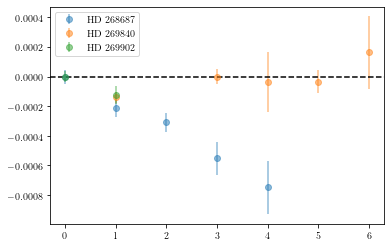

In [27]:
names = ['HD 268687', 'HD 269840', 'HD 269902']
f0_is = [5,0,1]
prefacs = [1,0.25,1]
n_harm_p1s = [6,10,5]

all_ocs = []
all_oc_errs = []
for j,(n,f0_i,pre,nharm) in enumerate(zip(names,f0_is,prefacs,n_harm_p1s)):
    print(n)

    good_fs = good_f_arrs[j]

    f0,f0_e = pre*good_fs[f0_i]
    cs = np.array([f0*(i+1) for i in range(nharm)])
    c_err = np.array([f0_e*(i+1) for i in range(nharm)])
    
    degs = []
    o_cs = []
    o_c_errs = []
    
    for f in good_fs:
        if np.min(np.abs(cs-f[0])) <= 0.01:
            deg = np.argmin(np.abs(cs-f[0]))
            c_close = cs[deg]
            c_close_err = c_err[deg]
            o_cs.append(f[0] - c_close)
            o_c_errs.append(np.sqrt(f[1]**2.0) + (c_close_err**2.0))
            degs.append(deg)
            print(cs,f[0],deg)
            if deg > -1:
                all_ocs.append(f[0] - c_close)
                all_oc_errs.append(np.sqrt(f[1]**2.0) + (c_close_err**2.0))
    plt.errorbar(np.array(degs),o_cs,yerr=o_c_errs,fmt='o',label=n,alpha=0.5)
all_ocs = np.array(all_ocs)
all_oc_errs = np.array(all_oc_errs)
plt.legend()
#plt.xlim(0.9,9.1)
#plt.ylim(-0.0025,0.0025)
plt.axhline(y=0,ls='--',c='k')

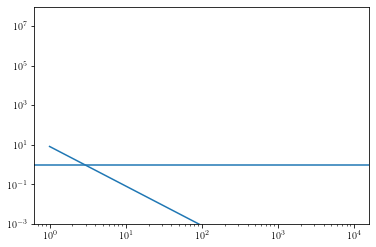

In [28]:
Ds = []
chi2s = []
for D in np.logspace(0,4,101):
    Ds.append(D)
    chi2_red = np.sum(np.power(all_ocs/(D*all_oc_errs),2.0))/len(all_ocs)
    chi2s.append(chi2_red)
plt.loglog(Ds,chi2s)
plt.ylim(0.001,1e8)
plt.axhline(y=1)

In [29]:
Ds[np.argmin(np.abs(np.array(chi2s) - 1))]

3.019951720402016